In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import re
from itertools import combinations 
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, \
                            confusion_matrix, plot_confusion_matrix, precision_recall_curve, plot_roc_curve, \
                            roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Conv1D, GlobalMaxPool1D, Embedding, SimpleRNN, LSTM
from keras.optimizers import RMSprop

In [2]:
from nltk.sentiment import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [3]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [4]:
data = pd.read_csv("new_processed_tweet.csv")[["tweet", "label"]]

In [5]:
test_data = pd.read_csv("new_processed_tweet_test.csv")[["tweet", "id"]]
test_id = test_data["id"]

### LSTM model

In [6]:
label = data[["label"]]
max_len = 60

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["tweet"])
sequence = tokenizer.texts_to_sequences(data["tweet"])

sequence = pad_sequences(sequence, maxlen=max_len, padding="post")

In [7]:
one_hot_encoder = OneHotEncoder()
label_nn = one_hot_encoder.fit_transform(label)

In [8]:
vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(vocab_size, 30, input_length=max_len))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=15, return_sequences=False))
model.add(Dense(16, activation="sigmoid"))
model.add(Dense(8, activation="sigmoid"))
model.add(Dense(2, activation="softmax"))

model.compile(loss="binary_crossentropy", optimizer=RMSprop(), metrics=["accuracy"])

In [9]:
weight = {0: 40, 1: 60}
history = model.fit(sequence, label_nn.todense(), batch_size=8, epochs=8, validation_split=0.2, verbose=2, class_weight=weight)

Epoch 1/8
792/792 - 18s - loss: 20.2497 - accuracy: 0.8111 - val_loss: 0.3697 - val_accuracy: 0.7980
Epoch 2/8
792/792 - 18s - loss: 12.6481 - accuracy: 0.9003 - val_loss: 0.2777 - val_accuracy: 0.9009
Epoch 3/8
792/792 - 19s - loss: 10.9081 - accuracy: 0.9157 - val_loss: 0.2944 - val_accuracy: 0.8845
Epoch 4/8
792/792 - 21s - loss: 10.1349 - accuracy: 0.9200 - val_loss: 0.2563 - val_accuracy: 0.8965
Epoch 5/8
792/792 - 21s - loss: 9.6770 - accuracy: 0.9235 - val_loss: 0.2766 - val_accuracy: 0.8857
Epoch 6/8
792/792 - 21s - loss: 9.1244 - accuracy: 0.9253 - val_loss: 0.2846 - val_accuracy: 0.8939
Epoch 7/8
792/792 - 21s - loss: 9.1253 - accuracy: 0.9301 - val_loss: 0.3019 - val_accuracy: 0.8813
Epoch 8/8
792/792 - 22s - loss: 8.5375 - accuracy: 0.9354 - val_loss: 0.2733 - val_accuracy: 0.8813


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 30)            442650    
_________________________________________________________________
lstm (LSTM)                  (None, 60, 30)            7320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 15)                2760      
_________________________________________________________________
dense (Dense)                (None, 16)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
Total params: 453,140
Trainable params: 453,140
Non-trainable params: 0
__________________________________________________

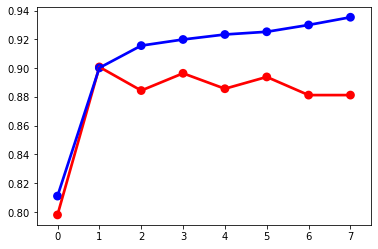

In [11]:
sns.pointplot(history.epoch, history.history["val_accuracy"], color="red")
sns.pointplot(history.epoch, history.history["accuracy"], color="blue")

In [12]:
test_sequence = tokenizer.texts_to_sequences(test_data["tweet"])

test_sequence = pad_sequences(test_sequence, maxlen=max_len, padding="post")

In [13]:
prediction_LSTM = pd.DataFrame({"label": model.predict_classes(test_sequence)})
prediction_LSTM["id"] = test_id
prediction_LSTM.set_index("id", inplace=True)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [14]:
prediction_LSTM["label"].value_counts(normalize=True)

0    0.729647
1    0.270353
Name: label, dtype: float64

In [15]:
prediction_LSTM.to_csv("prediction_LSTM.csv")

In [16]:
data["tweet"].iloc[34]

'just receive the samsung note many thank to cottds phone'